# A first-draft statistical model of London local election results

The aim of the Campaign Lab event was to gather interesting sources of political data. One of the ideas floating around was to use publicly available data about wards and local authorities to say something useful about Labour's recent local election results. For example, we might identify targets by looking for areas where things have happened that correlate well with Labour vote. Working in the other direction it is also interesting to look for wards where the Labour vote was higher or lower than would be expected given the information available to the model - this can unearth otherwise hidden dynamics or potentially highlight cases where local campaigning has been particularly effective.

This notebook gives a very first-draft example of the kind of model that might be useful for linking all of this data. 

The analysis uses [this Britain Elects spreadsheet](https://docs.google.com/spreadsheets/d/14GKPoj-E1CN0ZmiUd5gQWUi5zvGWbDoNoGT82RqKEno/edit?ts=5b07edf9#gid=0) of data about the recent local elections in London, and [this ONS data] about income levels in local authorities. The model only takes into account three facts about each ward besides its Labour vote share in 2018, namely the local authority it is in, that authority's latest available median income and its Labour vote share in the 2014 local elections. It should be fairly straightforward from a modelling point of view to extend the model to incorporate other numerical or categorical facts about wards and local authorities. 

### Fetching the data

The first code cell imports some python libraries, fetches the data from the online spreadsheet and does a little bit of preliminary tidying.

The data about election results is downloaded in the cell, whereas local authority level income data has to be downloaded manually from [here](https://beta.ons.gov.uk/filter-outputs/858e0eae-709b-4bb3-ad31-f730c73d68c1).
 
We end up with a pandas [dataframe](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) holding facts about wards, the top of which is displayed below.

In [1]:
import pandas as pd
import pystan
from matplotlib import pyplot as plt

# a matplotlib style file I put in this repo - not essential!
plt.style.use("sparse.mplstyle")

# fetch data from online spreadsheet
spreadsheet_url = ("https://docs.google.com/spreadsheets/d/" +
                   "14GKPoj-E1CN0ZmiUd5gQWUi5zvGWbDoNoGT82RqKEno/" +
                   "export?&format=csv")
wards = pd.read_csv(spreadsheet_url, skiprows=2, na_values=['#VALUE!', '#DIV/0!'])

# drop some blank columns
to_drop = [col for col in wards.columns if 'Unnamed' in col]
wards = wards.drop(to_drop, axis=1)

# manually copied column names
wards.columns = [
    'Authority', 'Ward', 'Constituency', 'seats',
    'seatsCon', 'seatsLab', 'seatsLDem', 'seatsUKIP', 'seatsGrn', 'seatsInd', 'seatsOth',
    'lastResultCon', 'lastResultLab', 'lastResultLDem', 'lastResultUKIP', 'lastResultGrn', 'lastResultInd', 'lastResultOth',
    'votesCon', 'votesLab', 'votesLDem', 'votesUKIP', 'votesGrn', 'votesInd', 'votesOth',
    'pctCon', 'pctLab', 'pctLDem', 'pctUKIP', 'pctGrn', 'pctInd', 'pctOth',
    'pctPmCon', 'pctPmLab', 'pctPmLDem', 'pctPmUKIP', 'pctPmGrn', 'pctPmInd', 'pctPmOth',
    'lastVotesCon', 'lastVotesLab', 'lastVotesLDem', 'lastVotesUKIP', 'lastVotesGrn', 'lastVotesInd', 'lastVotesOth',
    'lastPctCon', 'lastPctLab', 'lastPctLDem', 'lastPctUKIP', 'lastPctGrn', 'lastPctInd', 'lastPctOth'
    
]

# load income data
latest_income_stats = (
    pd.read_csv("../data/income_data.csv")
    .rename(columns={'Geography': 'Authority', 'V4_2': 'income'})
    .assign(Authority=lambda df: df['Authority'].str.replace('and ', '& '))
    .loc[lambda df: df['income'].notnull()]
    .groupby(['Authority', 'Statistics'])
    .apply(lambda g: g.sort_values('Time')['income'].iloc[-1])
    .unstack()
)
latest_income_stats.columns = ['authority_income_mean', 'authority_income_median']


wards = wards.join(latest_income_stats, on='Authority')

wards.head()

,Authority,Ward,Constituency,seats,seatsCon,seatsLab,seatsLDem,seatsUKIP,seatsGrn,seatsInd,...,lastVotesOth,lastPctCon,lastPctLab,lastPctLDem,lastPctUKIP,lastPctGrn,lastPctInd,lastPctOth,authority_income_mean,authority_income_median
0,Barking & Dagenham,Abbey,NaN,3,NaN,3.0,NaN,NaN,NaN,NaN,...,94.0,10.4,57.3,5.6,16.5,7.8,0.0,2.4,25896.0,24593.0
1,Barking & Dagenham,Alibon,NaN,3,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,8.1,51.1,5.2,35.6,0.0,0.0,0.0,25896.0,24593.0
2,Barking & Dagenham,Becontree,NaN,3,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,8.6,61.7,4.4,25.2,0.0,0.0,0.0,25896.0,24593.0
3,Barking & Dagenham,Chadwell Heath,NaN,3,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,12.0,45.1,5.1,27.7,10.2,0.0,0.0,25896.0,24593.0
4,Barking & Dagenham,Eastbrook,NaN,3,NaN,3.0,NaN,NaN,NaN,NaN,...,222.0,15.8,45.8,0.0,32.0,0.0,0.0,6.4,25896.0,24593.0


The next cell fetches in a statistical model definition in the form of a Stan program, compiles it into a Stan model object, and prints the program. This is a convenient time to go into a bit of detail about the model itself.

The model is an example of linear regression: it assumes that, from ward to ward, Labour vote shares will tend to differ from a expected value in a random, normally distributed way. The expected value - `labour_vote_hat` in the code below - depends on the following model parameters (it is just their sum):

- the average labour vote share for all of London (`mu`)
- a number specific to the ward's local authority (`authority_effect`)
- some numerical, ward-specific predictors multiplied by some regression coefficients (the predictors are `X_ward` and coefficients are `b_ward`)

The amount that the model expects the observed values to vary from the expected ones is specified by another parameter `sigma_ward`.

The `authority_effect` parameters has its own predictors (`X_authority`) and parameters (`b_authority` and `sigma_authority`). This makes the overall model a multilevel model - there is a level for wards and a level for local authorities. Factoring the overall variation in Labour vote shares into two components like this is nice for two reasons. First, it helps us to interpret the results - for example we can check which local authorities tended to be particularly Labour-leaning. Secondly, this form of model lines up neatly with the information that we want to take into account, which also has a multi-level structure.

Together with some prior distributions, the model defines a probability distribution which encodes what the data (along with our/its assumptions) say about all of these parameters. In order to answer statistical questions about this distribution - for example, to find out the average local authority effect for Barking & Dagenham - we need to use Markov Chain Monte Carlo to take approximate samples from it. Fortunately Stan makes it straightforward to use the latest techniques to do this.


Some further reading about MCMC and multilevel models:

 - [A really nice visualisation of Hamiltonian Monte Carlo](https://chi-feng.github.io/mcmc-demo/app.html#NaiveNUTS,banana)
 - [A paper about the history of Markov Chain Monte Carlo](https://arxiv.org/abs/1706.01520)
 - [A conceptual introduction to Hamiltonian Monte Carlo (with pictures!)](https://arxiv.org/abs/1701.02434)
 - [A very nice blog post about Hamiltonian Monte Carlo](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/)
 - [What are multilevel models and why should I use them?](http://www.bristol.ac.uk/cmm/learning/multilevel-models/what-why.html)
 - [A case study applying multi-level modelling of baseball (and explaining why multi-level models are useful)](http://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html)


In [2]:
model = pystan.StanModel(file="../stan/local_election_model.stan")
print(model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7cc8aa493c0e8114eb1f4bbefb377df9 NOW.


/*
  Multi-level regression model of factors affecting local election results for
  council wards, with ward and local authority level predictors.
*/
data {
  int<lower=1> N_ward;                               // number of wards 
  int<lower=1> N_authority;                          // number of local authorities 
  int<lower=1> K_ward;                               // number of ward level predictors
  int<lower=1> K_authority;                          // number of local authority level predictors
  matrix[N_authority, K_authority] X_authority;      // authority-level predictors
  matrix[N_ward, K_ward] X_ward;                     // ward-level predictors
  int<lower=1,upper=N_authority> authority[N_ward];  // maps wards to authorities
  vector[N_ward] labour_vote;                        // response variable
}
parameters {
  vector[K_ward] b_ward;
  vector[K_authority] b_authority;
  vector[N_authority] authority_error_z;
  real mu;
  real<lower=0> sigma_ward;
  real<lower=0> sigma_auth

The next cell does some pretty mundane operations on our dataframe of ward data in order to make it easy to feed into the model. 

The most interesting thing is that, if you add any new predictors to the `wards` dataframe, you can include them in the model just by adding their column names to either `ward_level_predictors` or `authority_level_predictors` below.

In [3]:
def stanify_series(s):
    return pd.Series(s.fillna('value_missing').factorize()[0] + 1, index=s.index)

def z_score(s):
    return (s - s.mean()) / s.std()

# types!
categorical_cols = ['Authority', 'Ward', 'Constituency']
int_cols = ['seats']
float_cols = ['pctLab', 'lastPctLab']
wards[float_cols] = wards[float_cols].astype(float)

# nans
wards = wards.dropna(subset=['pctLab', 'lastPctLab'])

# there are some annoying duplicate names!
wards['WardUnique'] = wards[['Authority', 'Ward']].apply('-'.join, axis=1)

# factorise the categorical variables
wards['WardStan'] = wards['WardUnique'].pipe(stanify_series)
wards['AuthorityStan'] = wards['Authority'].pipe(stanify_series)

# specify predictors
ward_level_predictors = ['lastPctLab']
authority_level_predictors = ['authority_income_median']

# dataframe of authority-level predictors
x_authority = wards.groupby('AuthorityStan')[authority_level_predictors].first()

# define model input
model_input = {
    'N_ward': len(wards),
    'N_authority': wards['Authority'].nunique(),
    'K_ward': len(ward_level_predictors),
    'K_authority': len(authority_level_predictors),
    'authority': wards['AuthorityStan'],
    'X_ward': wards[ward_level_predictors].apply(z_score),
    'X_authority': x_authority.apply(z_score),
    'labour_vote': wards['pctLab']
}

Now we draw samples - this should be pretty quick with our smallish dataset and few predictors.

In [4]:
chains = 4
n_iterations = 2000
sample_file = '../data/samples/samples.csv'
fit = model.sampling(data=model_input, chains=chains, iter=n_iterations, sample_file=sample_file)

/Users/teddy/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


First some diagnostic checking, doing my best to follow the approach outlined [here](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html). 

The next cell checks for [post-warmup divergent transitions](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html). There aren't any so that's good!

In [5]:
def get_diagnostic_dataframe(fit, include_warmup=False):
    first = 0 if include_warmup else fit.sim['warmup']
    chain_dfs = [pd.DataFrame(d).iloc[first:] for d in fit.get_sampler_params()]
    return pd.concat(chain_dfs)

get_diagnostic_dataframe(fit).max()

accept_stat__       1.000000
stepsize__          0.299636
treedepth__         6.000000
n_leapfrog__      111.000000
divergent__         0.000000
energy__         1558.138567
dtype: float64

Now we extract a table that summarises the posterior distributions for some parameters.

First we note that the [Rhat statistics](http://www.mcmchandbook.net/HandbookChapter6.pdf) are close to one for all of the parameters shown, and the effective sample sizes are easily large enough to make sampling error practically irrelevant.

Here is what the summary says about specific parameters:
- `mu` The mean of the posterior distribution for average Labour vote share is about 45% - this is about right
- `b_ward` This parameter represents the effect on expected 2018 Labour vote share of one stanard deviation's worth of change in 2014 share. As you would think, a higher previous Labour vote share predicts a higher 2018 share by about 15% per standard deviation.
- `b_authority` - this parameter corresponds to the income predictor - a one standard deviation change in median income predicts about a 1.3 percentage point decrease in authority effect.
- `sigma_ward` - this is the final error standard deviation, indicating how much the observed Labour vote shares tended to differ from the predictions. About 7% seems more or less plausible.
- `sigma_authority` - this is the standard deviation of the authority effect

In [6]:
def summarise_fit(fit, pars=None):
    if pars is None:
        pars = fit.model_pars
    summary = fit.summary(pars=pars)
    return pd.DataFrame(summary['summary'], 
                        columns=summary['summary_colnames'], 
                        index=summary['summary_rownames'])

parameters_to_show = ['lp__', 'mu', 'b_ward', 'b_authority', 'sigma_ward', 'sigma_authority']

summarise_fit(fit, pars=parameters_to_show)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
lp__,-1516.660509,0.186504,5.504245,-1528.363168,-1520.239604,-1516.398098,-1512.778674,-1506.650749,871.0,1.007313
mu,45.373569,0.033834,1.000262,43.410886,44.695315,45.385819,46.034847,47.318795,874.0,1.000550
b_ward[0],15.278478,0.007589,0.439125,14.405162,14.990013,15.284558,15.573158,16.147333,3348.0,1.001384
b_authority[0],-1.279725,0.018979,0.736770,-2.712633,-1.774811,-1.270002,-0.781064,0.174491,1507.0,1.001138
sigma_ward,7.295039,0.003842,0.242960,6.850125,7.126008,7.289534,7.448697,7.800239,4000.0,1.001085
sigma_authority,5.015146,0.021389,0.767610,3.730779,4.492171,4.947007,5.450760,6.804018,1288.0,1.002158


What about the individual wards? The next cell looks at some facts about the wards that the model found most surprising, as measured by the log-scale probability of their Labour votes. These are the wards we might look at in order to discover interesting unmodelled effects.

The most surprising ward is Hackney/Cazenove - its Labour vote share increased dramatically from 39% to over 90%, whereas the model's expected share was only 50%. In Newham/Stratford & New Town, the Labour share was much lower than expected at 43&, whereas the model thought it would be about 79%.

In [8]:
authority_output = pd.DataFrame({
    'authority_effect_mean': fit['authority_effect'].mean(axis=0),
}, index=wards.groupby('AuthorityStan')['Authority'].first())

ward_output = pd.DataFrame({
    'labour_vote_hat_mean': fit['labour_vote_hat'].mean(axis=0),
    'log_likelihood_mean': fit['log_likelihood'].mean(axis=0),
    'pctLab': wards['pctLab'].values,
    'lastPctLab': wards['lastPctLab'].values,
    'authority_income_median': wards['authority_income_median'].values
}, index=pd.MultiIndex.from_tuples(wards[['Authority', 'Ward']].apply(tuple, axis=1)))

ward_output.index.names = ['Authority', 'Ward']
ward_output = ward_output.join(authority_output, on='Authority')

ward_output.sort_values('log_likelihood_mean').iloc[:10]

,,labour_vote_hat_mean,log_likelihood_mean,pctLab,lastPctLab,authority_income_median,authority_effect_mean
Authority,Ward,,,,,,
Hackney,Cazenove,49.537726,-19.377254,91.3,38.6,30000.0,3.852352
Newham,Stratford & New Town,78.962423,-15.126457,43.0,72.6,23441.0,4.119344
Ealing,Southall Broadway,44.804286,-11.926601,75.7,38.2,26919.0,-0.538056
Enfield,Grange,35.133567,-8.082950,58.5,23.9,25244.0,2.054613
Hackney,Shacklewell,70.719941,-7.774462,93.4,63.3,30000.0,3.852352
Lambeth,Gipsy Hill,67.407024,-7.011860,46.6,67.0,31215.0,-2.633610
Tower Hamlets,Weavers,40.018200,-6.469015,59.4,31.8,32581.0,0.164368
Westminster,Harrow Road,62.150899,-6.418452,81.4,57.6,38110.0,0.171514
Enfield,Enfield Highway,54.686381,-5.688359,71.8,46.7,25244.0,2.054613


To get an idea of the overall variation, the last cell plots 2018 and 2014 Labour shares for all the wards in the Britain Elects dataset, along with the model's posterior credible intervals. Ideally, we should see about 70% of the blue dots inside the dark orange region, and 95% of them inside the lighter one, and there should be no particular pattern in the errors.

This is in fact more or less what the plot shows, though there does seem to be a pattern - the dots on the left, where the model was predicting a low Labour share, seem to have generally been even lower than it thought they would be. This suggests something we might look at closer - what was special about those wards?

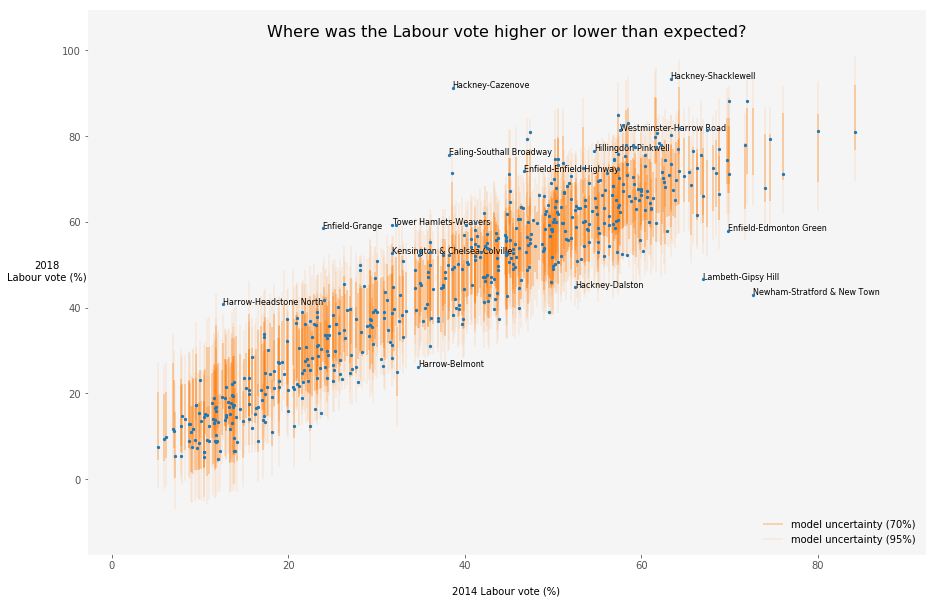

In [9]:
posterior_predictive_samples = pd.DataFrame(fit['labour_vote_tilde'], columns=ward_output.index)
log_likelihood_samples = pd.DataFrame(fit['log_likelihood'], columns=ward_output.index)

lower_quantile = 0.15
upper_quantile = 0.85
lower_quantile_2 = 0.025
upper_quantile_2 = 0.975

ppc_mean = posterior_predictive_samples.mean()
ppc_lower = posterior_predictive_samples.quantile(lower_quantile)
ppc_upper = posterior_predictive_samples.quantile(upper_quantile)
ppc_lower_2 = posterior_predictive_samples.quantile(lower_quantile_2)
ppc_upper_2 = posterior_predictive_samples.quantile(upper_quantile_2)

f, ax = plt.subplots(figsize=[15, 10])
plt.scatter(ward_output['lastPctLab'], ward_output['pctLab'], s=5, label=None, zorder=4)
plt.vlines(ward_output['lastPctLab'], ppc_lower, ppc_upper, color='tab:orange', alpha=0.4, label='model uncertainty (70%)')
plt.vlines(ward_output['lastPctLab'], ppc_lower_2, ppc_upper_2, color='tab:orange', alpha=0.1, label='model uncertainty (95%)')

for i in log_likelihood_samples.mean().sort_values().iloc[:15].index.values:
    plt.text(ward_output['lastPctLab'].loc[i], ward_output.loc[i, 'pctLab'], '-'.join(i), fontsize=8)


ax.set_title("Where was the Labour vote higher or lower than expected?", y=0.9, fontsize=16)

plt.xlabel("2014 Labour vote (%)")
plt.ylabel("2018\nLabour vote (%)", rotation=0)
plt.legend(frameon=False, loc='lower right')

plt.show()